# Inpainting with homogeneous diffusion 
We will test the performance of Matern Kernel as an interpolation method for missing data. The method is described in http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.172.7777&rep=rep1&type=pdf. 

In [1]:
using Laplacians, LinearAlgebra, SparseArrays
using TestImages, Colors, Plots, FileIO, JLD, BenchmarkTools
using LaTeXStrings, NPZ

In [2]:
h = 0.05
x_array = 0:h:5;
x_array = collect(x_array);
N = length(x_array);
all = collect(1:length(x_array));
keep = [1,11,31,71,81,101];
discard = setdiff(all,keep);
f_array=zeros(N);
f_array[1] = 0.0;
f_array[11] = 0.8;
f_array[31] = 1.5;
f_array[71] = 0.9;
f_array[81] = 1.1;
f_array[101] = 1.4;
print(size(discard))

(95,)

In [3]:
#Constructing the Laplace matrix

ev = 1/h^2*ones(N-1,1);
dv = -ones(N,1)*2/h^2

function Matern1D(h,N,f_array, args...)
A= Tridiagonal([fill(-1.0/h^2, N-2); 0], [1.0; fill(2.0/h^2, N-2); 1.0], [0.0; fill(-1.0/h^2, N-2);]);
#A = Tridiagonal([ev, dv, ev]);
sizeA = size(A,1);
epsilon = 2.2
for i = 1:sizeA
    A[i,i] = A[i,i] + epsilon^2
end
A2 = A*A;
diag_c = ones(N);
for i in discard
    diag_c[i] = 0;
end
#diag_c[discard] .= 0;
C = diagm(diag_c);
Id = Matrix(1.0I, N,N);
return (C-(Id -C)*A2)\(C*f_array);
end

@btime Matern1D(h,N,f_array)

  812.734 μs (187 allocations: 510.25 KiB)


101-element Array{Float64,1}:
 -3.113023509250903e-13
  0.08768065792924375
  0.17500391946490496
  0.2615909018949182
  0.3470192822293239
  0.4308003997835029
  0.5123549230204436
  0.5909865633341254
  0.6658532844675056
  0.7359354127766411
  0.7999999998918643
  0.856560724642831
  0.9073284321563228
  ⋮
  1.1513698763222344
  1.1641790152727804
  1.1796580865073647
  1.1978097970029002
  1.218528817865971
  1.2415965777816764
  1.2666729401159673
  1.2932845942583726
  1.3208099300750165
  1.3484600987310957
  1.3752558925646599
  1.4

In [4]:
#Constructing C

u = (C-(Id -C)*A2)\(C*f_array);
# u = (C-(Id -C)*A2)\(C*f_array);

LoadError: UndefVarError: Id not defined

In [5]:

pa = plot(x_array[keep], f_array[keep], seriestype = :scatter, label="Data", legendfont=font(10), xtickfont=font(18), 
    ytickfont=font(10), ylim=[0,1.6])
pb = plot!(x_array, u, label = "epsilon=0.1", legendfont=font(10), xtickfont=font(18), ytickfont=font(18), lw=3 )
pc = plot!(x_array, u1, label="epsilon=1", legendfont=font(10), xtickfont=font(18), ytickfont=font(18), lw=3 )
pd = plot!(x_array, u2, label="epsilon=2", legendfont=font(10), xtickfont=font(18), ytickfont=font(18), lw=3 , legend=:bottomright)

LoadError: UndefVarError: u not defined

In [6]:
#Verifying if the second derivative at the discarded points is 0
norm((A*u)[discard])

LoadError: UndefVarError: A not defined

# 2D Example
We will use the Mandrill image to test the approach.


(512, 512)(512, 512)

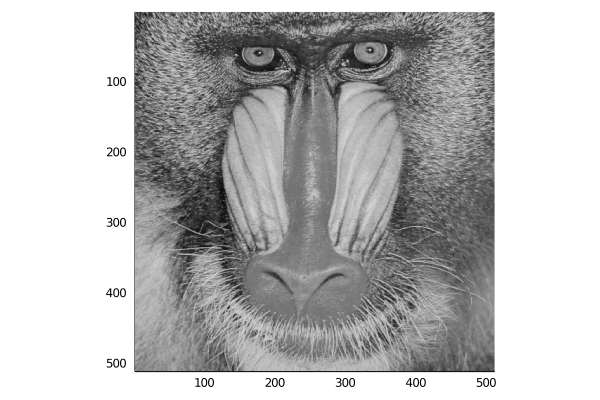

In [7]:
img = testimage("mandrill");
print(size(img))
imgg = Gray.(img);
print(size(imgg))
mat = convert(Array{Float64}, imgg)[1:256,1:512];
# This image is square
plot(imgg)

In [8]:
rows = size(mat,1);
columns = size(mat,2);
BoundaryNodes1 = collect(1:rows);
BoundaryNodes2 = collect(rows+1:rows:rows*columns-rows+1);
BoundaryNodes3 = collect(rows*columns-rows+2:rows*columns);
BoundaryNodes4 = collect(2*rows:rows:(columns-1)*rows);
BoundaryNodes= union(BoundaryNodes1, BoundaryNodes2, BoundaryNodes3, BoundaryNodes4);
AllNodes = collect(1:rows*columns)
NonBoundaryNodes = setdiff(AllNodes, BoundaryNodes);
size(NonBoundaryNodes);

In [9]:
#Now we discard about 50% of the non boundary nodes
No_of_nodes_discarded = 60000
discard = rand(1:length(NonBoundaryNodes), No_of_nodes_discarded);
discard = unique(discard);
discard = NonBoundaryNodes[discard];

In [10]:
#Constructing the 2D Laplace matrix
function spdiagm_nonsquare(m, n, args...)
    I, J, V = SparseArrays.spdiagm_internal(args...)
    return sparse(I, J, V, m, n)
end

# returns -∇² (discrete Laplacian, real-symmetric positive-definite) on n₁×n₂ grid
function ∇²(n₁,n₂)
    o₁ = ones(n₁)
    ∂₁ = spdiagm_nonsquare(n₁+1,n₁,-1=>-o₁,0=>o₁)
    o₂ = ones(n₂)
    ∂₂ = spdiagm_nonsquare(n₂+1,n₂,-1=>-o₂,0=>o₂)
    return kron(sparse(I,n₂,n₂), ∂₁'*∂₁) + kron(∂₂'*∂₂, sparse(I,n₁,n₁))
end



∇² (generic function with 1 method)

In [11]:
A = ∇²(rows,columns);
epsilon = 0.1;
sizeA = size(A,1);
for i = 1:sizeA
    A[i,i] = A[i,i] + epsilon^2
end

In [12]:
#Enforcing Dirichlet Boundary conditions
A[BoundaryNodes,:] .= 0
A[:,BoundaryNodes] .= 0
A[BoundaryNodes, BoundaryNodes] = sparse(I, length(BoundaryNodes), length(BoundaryNodes));
A;
holeyimage1 = mat;
holeyimage1[discard].=1
plot(Gray.(holeyimage1), title="Image with Missing data")
Plots.savefig("Mandrill_missing.png")
mat = convert(Array{Float64}, imgg)[1:256,1:512];

In [13]:
#Constructing C
C = sparse(I, rows*columns, rows*columns)
for i in discard
    C[i,i] = 0;
end
#C[discard,discard] .= 0
Id = sparse(I, rows*columns,rows*columns);
f = mat[:];
u =((C-(Id -C)*A)) \ (C*f);
restored_img = reshape(u, size(mat,1), size(mat,2));
plot(Gray.(restored_img), title="Inpainting_Homogeneous_Diffusion")
Plots.savefig("Mandrill_Reconstructed.png")

In [14]:
plot(imgg[1:size(mat,1),1:size(mat,2)], title="Original")
#savefig("Mandrill_Truth.png")
A_new  = ∇²(rows,columns);
maximum((A_new*u)[discard] .< 1e-6) == length(discard);

In [15]:
maximum((A_new*u)[discard])

-0.0006275244346382741

# Adding holes to the Mandrill Image

In [16]:
cent = [(100, 200), (200, 100), (400, 200)]
c = cent[1]
rad = 20

L = 1:size(mat,1)
K = 1:size(mat,2)

mask = ones(size(mat))
mask = broadcast(+, (L .- c[1]).^2, (K .- c[2])'.^2) .> rad^2

keep = collect(1:prod(size(mat)))

fun(c, k) = filter(x -> (floor(x/size(mat,1)) .- c[1]).^2 + (x%size(mat,1) .- c[2])'.^2 > rad^2, k)

keep = fun(cent[1], keep)
keep = fun(cent[2], keep)
keep = fun(cent[3], keep)

prod(size(mask)) - sum(mask[keep]), 2*20^2*pi;
print(size(keep))

(127301,)

In [17]:
S = [i*size(mat,2)+j for i in 0:(size(mat,1)-1) for j in 1:size(mat,2)]
vals = mat[:]
holeyimage = ones(size(mat,1),size(mat,2))
holeyimage[S[keep]] = vals[keep]
print(size(holeyimage))
plot(Gray.(holeyimage))
#Plots.savefig("MandrilWithHoles.png")

(256, 512)

In [18]:
discard = setdiff(AllNodes, keep);

In [19]:
npzwrite("holeyimage.npy", holeyimage)
holeyimage_convolve_restored = npzread("holeyimage_restored.npy")
plot(Gray.(holeyimage), title="Convolution")

LoadError: SystemError: opening file "holeyimage_restored.npy": No such file or directory

In [20]:
function Matern2D(rows, columns, discard, mat, BoundaryNodes, args...)
A = ∇²(rows,columns);
epsilon = 0.3;
sizeA = size(A,1);
for i = 1:sizeA
    A[i,i] = A[i,i] + epsilon^2
end
C = sparse(I, rows*columns, rows*columns)
# A[BoundaryNodes,:] .= 0
# A[:,BoundaryNodes] .= 0

A[BoundaryNodes, BoundaryNodes] = sparse(I, length(BoundaryNodes), length(BoundaryNodes));
for i in BoundaryNodes
    rowindices = A.rowval[nzrange(A, i)];
    A[rowindices,i].=0;
    A[i,i] = 1.0
end


for i in discard
    C[i,i] =0.
end
A2 = A*A;
#C[discard,discard] .= 0
Id = sparse(I, rows*columns,rows*columns);
f = mat[:];
return ((C-(Id -C)*A2)) \ (C*f);
# ml = ruge_stuben(((C-(Id -C)*A2)))
# u_amg = solve(ml, (C*f))
#return restored_img = reshape(u, size(mat,1), size(mat,2));
end
@btime Matern2D(rows, columns, discard, mat, BoundaryNodes)

# plot(Gray.(restored_img), title="Inpainting_Homogeneous_Diffusion")
# GaussianConv2DInterp = npzread("GaussianConvolution2D.npy")
# plot1 = plot(Gray.(restored_img), title="Matern Kernel");
# plot2 = plot(Gray.(GaussianConv2DInterp), title="Gaussian Interpolation");
# plot(plot1) 
# #savefig("MandrilWithHolesRestored.png")

  83.015 ms (1789 allocations: 186.90 MiB)


In [21]:
save("Mandrill_Holes_Restored_Global.jld", "Mandrill_Holes_Restored_Global", u)
sum((A_new*u)[discard] .< 1e-6) == length(discard)

false

In [22]:
#Constructing the 3D Laplace matrix
function spdiagm_nonsquare(m, n, args...)
    I, J, V = SparseArrays.spdiagm_internal(args...)
    return sparse(I, J, V, m, n)
end

# returns -∇² (discrete Laplacian, real-symmetric positive-definite) on n₁×n₂ grid
function ∇²3d(n₁,n₂,n3)
    o₁ = ones(n₁)
    ∂₁ = spdiagm_nonsquare(n₁+1,n₁,-1=>-o₁,0=>o₁)
    o₂ = ones(n₂)
    ∂₂ = spdiagm_nonsquare(n₂+1,n₂,-1=>-o₂,0=>o₂)
    O3 = ones(n3)
    del3 = spdiagm_nonsquare(n3+1,n3,-1=>-O3,0=>O3)
    return kron(sparse(I,n3,n3),sparse(I,n₂,n₂), ∂₁'*∂₁) + kron(sparse(I,n3,n3), ∂₂'*∂₂, sparse(I,n₁,n₁)) + kron(del3'*del3, sparse(I,n₂,n₂), sparse(I,n₁,n₁))
end

∇²3d (generic function with 1 method)

We will now solve a simple Poisson problem $-\Delta u =  f $ with homogeneous Dirichlet boundary conditions to verify the correctness of our Laplace operator. We will use the method of manufactured solutions with $u = \sin(2 \pi x) \sin(2\pi y) \sin(2\pi z)$.

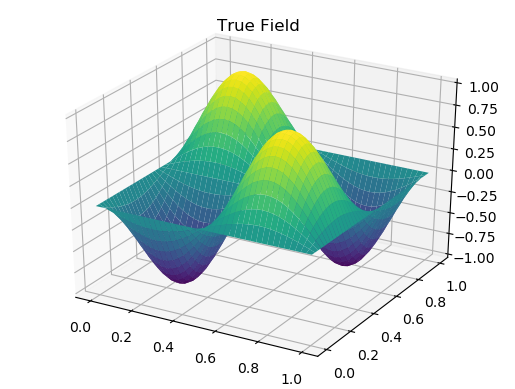

PyObject Text(0.5, 0.92, 'True Field')

In [23]:
using VectorizedRoutines, PyPlot
h = 0.025
x_dir = collect(0:h:1);
y_dir = collect(0:h:1);
z_dir = collect(0:h:1);
xmesh, ymesh, zmesh = Matlab.meshgrid(x_dir, y_dir, z_dir);
u_true = sin.(2*pi*xmesh).*sin.(2*pi*ymesh).*sin.(2*pi*zmesh);
surf(xmesh[:,:,1], ymesh[:,:,1], u_true[:,:,31], cmap=ColorMap("viridis"));
title("True Field")

In [24]:
ngrid = convert(Int64, 1/h+1);
rhs_f = -12*pi^2*sin.(2*pi*xmesh).*sin.(2*pi*ymesh).*sin.(2*pi*zmesh);
rhs_f = rhs_f[:];
A3D = -∇²3d(ngrid, ngrid, ngrid)/h^2;

In [25]:
function return_boundary_nodes(xpoints, ypoints, zpoints)
    BoundaryNodes3D =[];
    counter = 0;
    for k = 1:zpoints
        for j = 1:ypoints
            for i = 1:xpoints
                counter=counter+1;
                if(k == 1 || k == zpoints || j == 1|| j == ypoints || i == 1 || i == xpoints)
                    BoundaryNodes3D = push!(BoundaryNodes3D, counter)
                end
            end
        end
    end
    return BoundaryNodes3D
end
#bnodes = return_boundary_nodes(ngrid,ngrid,ngrid);


In [26]:
#Enforcing Dirichlet Boundary Conditions:
#Enforcing Dirichlet Boundary conditions
A3D[bnodes,:] .= 0
A3D[:,bnodes] .= 0
A3D[bnodes, bnodes] = sparse(I, length(bnodes), length(bnodes));
u_approx_vector = A3D\rhs_f;
u_approx = reshape(u_approx_vector, ngrid, ngrid, ngrid);
surf(xmesh[:,:,1], ymesh[:,:,1], u_approx[:,:,31], cmap=ColorMap("viridis"));

LoadError: UndefVarError: bnodes not defined

In [27]:
norm(u_approx[:] - u_true[:])
error = reshape(u_true[:] -u_approx[:], ngrid,ngrid,ngrid);
surf(xmesh[:,:,1], ymesh[:,:,1], error[:,:,31], cmap=ColorMap("viridis"));

zlim([-1,1])
title("Error")

LoadError: UndefVarError: u_approx not defined

In [28]:
AllNodes3D = collect(1:ngrid*ngrid*ngrid)
NonBoundaryNodes3D = setdiff(AllNodes3D, bnodes);

LoadError: UndefVarError: bnodes not defined

In [29]:
#Now we discard about 50% of the non boundary nodes
No_of_nodes_discarded = 30000
discard = rand(1:length(NonBoundaryNodes3D), No_of_nodes_discarded);
discard = unique(discard);
discard = NonBoundaryNodes3D[discard];

LoadError: UndefVarError: NonBoundaryNodes3D not defined

In [30]:
#Constructing C
C = sparse(I, ngrid*ngrid*ngrid, ngrid*ngrid*ngrid)
for i in discard
    C[i,i] = 0;
end
#C[discard,discard] .= 0
Id = sparse(I, ngrid^3,ngrid^3);
f = u_true[:];
u =((C-(Id -C)*A3D)) \ (C*f);
restored_img = reshape(u, ngrid, ngrid, ngrid);

LoadError: BoundsError: attempt to access 68921×68921 SparseMatrixCSC{Bool,Int64} at index [97480, 97480]

In [31]:
restored_img = reshape(u, ngrid, ngrid, ngrid);
surf(xmesh[:,:,1], ymesh[:,:,1], restored_img[:,:,31], cmap=ColorMap("viridis"));
zlim([-1,1])
title("Homogeneous Inpainting")

LoadError: DimensionMismatch("new dimensions (41, 41, 41) must be consistent with array size 131072")

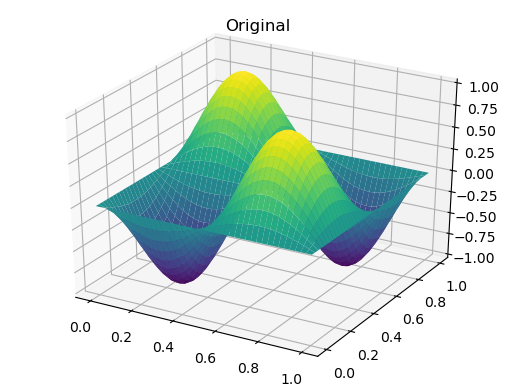

PyObject Text(0.5, 0.92, 'Original')

In [32]:
surf(xmesh[:,:,1], ymesh[:,:,1], u_true[:,:,31], cmap=ColorMap("viridis"))
title("Original")

In [33]:
surf(xmesh[:,:,1], ymesh[:,:,1], (u_true - restored_img)[:,:,31], cmap=ColorMap("viridis"))
zlim([-1,1])
title("Error")

LoadError: DimensionMismatch("dimensions must match: a has dims (Base.OneTo(41), Base.OneTo(41), Base.OneTo(41)), b has dims (Base.OneTo(256), Base.OneTo(512)), mismatch at 1")

In [34]:
maximum((A3D*u)[discard])

LoadError: DimensionMismatch("")

# 3D Giphy Example

In [35]:
# obj = load("/Users/vishwasrao/Research/BES_Project/2020_06_Jun/06112020_Meeting/giphy.gif")
# obj_copy = load("/Users/vishwasrao/Research/BES_Project/2020_06_Jun/06112020_Meeting/giphy.gif")

obj = load("/Users/vishwasrao/Research/BES_Project/Repo/laplaceinterpolation/cat_bow.gif")
obj_copy = load("/Users/vishwasrao/Research/BES_Project/Repo/laplaceinterpolation/cat_bow.gif")
print(size(obj_copy))

# 14 frames, here is the first one

imgg = Gray.(obj);
imgg_copy = Gray.(obj_copy);

LoadError: ArgumentError: No file exists at given path: /Users/vishwasrao/Research/BES_Project/Repo/laplaceinterpolation/cat_bow.gif

In [36]:
function punch_holes()
obj1 = rand(100,100,100);
cent = [(50,50,50)];
c = cent[1]
rad = 20;
L = size(obj1,1)
K = size(obj1,2)
M = size(obj1,3)
mask = ones(size(obj1))
count = 1;
for i = 1:L
    for j = 1:K
        for h = 1:M
            if((i-c[1])^2 + (j-c[2])^2 + (h - c[3])^2 > rad^2)
                mask[i,j,h] = 0;
            end
        end
    end
end

end
@benchmark punch_holes

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     0.035 ns (0.00% GC)
  median time:      0.037 ns (0.00% GC)
  mean time:        0.037 ns (0.00% GC)
  maximum time:     0.044 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1000

In [37]:
A = rand(2,3,4);

In [38]:
println(A[:])
for i = 1:4
    for j = 1:3
        for k = 1:2
            println(A[k,j,i])
        end
    end
end

[0.4526083640301535, 0.4064852770928651, 0.8420983308051389, 0.5069575878430481, 0.981206369144743, 0.21916840583139252, 0.9285691041042101, 0.9378046411240224, 0.31372289279249865, 0.06624379429346083, 0.9885370591900073, 0.6476758986028186, 0.5162593255502717, 0.4169078365493082, 0.522763165902937, 0.529659586889913, 0.2331272982743069, 0.5728129839587277, 0.002192594735957565, 0.7570059104148095, 0.44443175136257573, 0.45232763978264034, 0.536071391990157, 0.9283895950340932]
0.4526083640301535
0.4064852770928651
0.8420983308051389
0.5069575878430481
0.981206369144743
0.21916840583139252
0.9285691041042101
0.9378046411240224
0.31372289279249865
0.06624379429346083
0.9885370591900073
0.6476758986028186
0.5162593255502717
0.4169078365493082
0.522763165902937
0.529659586889913
0.2331272982743069
0.5728129839587277
0.002192594735957565
0.7570059104148095
0.44443175136257573
0.45232763978264034
0.536071391990157
0.9283895950340932


In [39]:
cent = [(50, 50,30), (50, 100,30), (50, 150,30), (100, 50, 30),
    (100, 100,30), (100, 150, 30)];
clen = length(cent);
masking_data_points = [];
absolute_indices = Int64[];

rad = 20
L = size(obj,1);
K = size(obj,2);
M = size(obj,3);


for a = 1:clen
    c=cent[a];
count = 1;
for i = 1:M
    for j = 1:K
        for h = 1:L
            if((h-c[1])^2 + (j-c[2])^2 + (i - c[3])^2 <= rad^2)
                #imgg_copy[h,j,i] = 1;
                append!(masking_data_points,[(h,j,i)]);
                append!(absolute_indices, count);
                    
            end
            count = count +1;
        end
    end
end
end



LoadError: UndefVarError: obj not defined

In [40]:
using GR
GR.inline()
img1 = Float64.(imgg_copy);
for i = 1:length(absolute_indices)
    img1[absolute_indices[i]] = 1.;
end
temp = Gray.(img1);
plot(temp[:,:,50])

# for n = 1:nsteps
#     IJulia.clear_output(true)
#     plot(imgg[:,:,n])  |> display
# end
# size(imgg)

LoadError: UndefVarError: imgg_copy not defined

In [41]:
AllNodesGiphy = 1:prod(size(imgg));

In [42]:
xpoints = size(imgg, 1);
ypoints = size(imgg, 2);
zpoints = size(imgg, 3);
imgg_temp = reshape(imgg, xpoints*ypoints*zpoints,1);
BoundaryNodesGiphy = return_boundary_nodes(xpoints,ypoints,zpoints);

In [43]:
discard = absolute_indices;
NonBoundaryNodesGiphy = setdiff(AllNodesGiphy, discard);
size(NonBoundaryNodesGiphy)

(262144,)

In [44]:
# No_of_nodes_discarded = 3000000;
# discard = rand(1:length(NonBoundaryNodesGiphy), No_of_nodes_discarded);
# discard = unique(discard);
# discard = absolute_indices;
# discard = NonBoundaryNodesGiphy[discard];
holeyimage3D = copy(imgg);
holeyimage3D[discard].=1
# npzwrite("imagetemp.npy", Float64.(imgg_temp));
# npzwrite("discarded.npy", discard)
temp = reshape(holeyimage3D, xpoints, ypoints, zpoints);
temp = Gray.(temp);
plot(temp[:,:,30])

LoadError: BoundsError: attempt to access 512×512×1 Array{Gray{N0f8},3} with eltype Gray{FixedPointNumbers.Normed{UInt8,8}} at index [1:512, 1:512, 30]

In [45]:

A3DGiphy = -∇²3d(xpoints, ypoints, zpoints);
for i in BoundaryNodesGiphy
    rowindices = A3DGiphy.rowval[nzrange(A3DGiphy, i)];
    A3DGiphy[rowindices,i].=0;
    A3DGiphy[i,i] = 1.0;
end



In [46]:
epsilon = 0.1;
sizeA = size(A3DGiphy,1);
for i = 1:sizeA
    A3DGiphy[i,i] = A3DGiphy[i,i] - epsilon^2
end
A3DMatern = A3DGiphy*A3DGiphy;
# for i in BoundaryNodes
#     rowindices = A3DGiphy.rowval[nzrange(A, i)];
#     for j in rowindices
#         A3DGiphy[j,i] =0;
#     end
#     A3DGiphy[i,i] = 1.0
# end
#A3DGiphy[BoundaryNodesGiphy, BoundaryNodesGiphy] = sparse(I, length(BoundaryNodesGiphy), length(BoundaryNodesGiphy));

totalsize = prod(size(imgg));
C = sparse(I, totalsize, totalsize)
for i in discard
    C[i,i] = 0;
end
#C[discard,discard] .= 0
Id = sparse(I, totalsize, totalsize);
f = holeyimage3D[:];
C*f
#u =((C-(Id -C)*A3DGiphy)) \ (C*f);
#restored_img = reshape(u, xpoints, ypoints, zpoints);

rhs_a = C*f;

rhs_a = Float64.(rhs_a);

u =((C-(Id -C)*A3DMatern)) \ rhs_a;

restored_img = reshape(u, xpoints, ypoints, zpoints);
restored_img = Gray.(restored_img);

In [47]:
# for n = 1:126
#     IJulia.clear_output(true)
#     plot1 = plot(imgg[:,:,n], title = "Original Image");
#     plot2 = plot(restored_img[:,:,n], title = "Restored Image");
#     plot(plot1, plot2, layout = (1, 2), legend = false) |>display
# end

plot1 = plot(imgg[:,:,30], title = "Original Image");
plot2 = plot(restored_img[:,:,30], title = "Restored Image");
plot3 = plot(temp[:,:,30], title = "Holey Image")
plot(plot1, plot3, plot2, layout = (1, 3), legend = false)

LoadError: BoundsError: attempt to access 512×512 Array{Gray{N0f8},2} with eltype Gray{FixedPointNumbers.Normed{UInt8,8}} at index [1:512, 1:512, 30]